## Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [72]:
(xTrain, yTrain), (xTest, yTest) = keras.datasets.fashion_mnist.load_data()

xTrain = tf.cast(xTrain.reshape(-1, 28, 28, 1) / 255.0 * 2.0 - 1.0, dtype=tf.float32)
xTrain, xValid = xTrain[5000:], xTrain[:5000]

xTest = tf.cast(xTest.reshape(-1, 28, 28, 1)/255.0 * 2.0 - 1.0, dtype=tf.float32)

yTrain, yValid = yTrain[5000:], yTrain[:5000]

4422102/4422102 [==============================] - 0s 0us/step


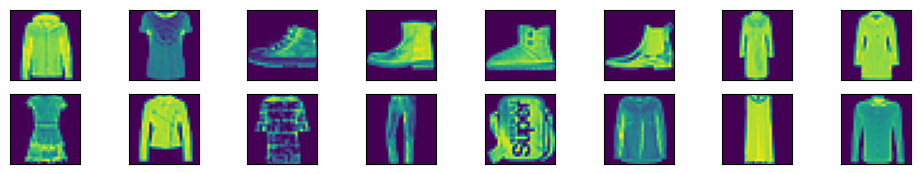

In [73]:
def plot_some_samples(samples):
    fig = plt.figure(figsize=(12, 2))

    for i in range(len(samples)):
        ax = fig.add_subplot(2, 8, i+1)
        ax.imshow(samples[i])
        plt.xticks([]), plt.yticks([])

    plt.show()

plot_some_samples(xTrain[:16, ...])

## Generator | Data

In [170]:
batch_size = 128
img_height, img_width = 28, 28
img_channels = 1

codings_size = 64

In [171]:
dataset = tf.data.Dataset.from_tensor_slices(xTrain).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [181]:
class Generator(keras.Model):
    def __init__(self, name: str = 'generator', **kwargs):
        super(Generator, self).__init__(name=name, **kwargs)

        block = []
        input_size = 7 * 7 * batch_size
        
        block.append(keras.layers.Dense(units=input_size, input_shape=[codings_size]))
        block.append(keras.layers.Reshape([7, 7, batch_size]))
        block.append(keras.layers.BatchNormalization())
        block.append(keras.layers.Activation('selu'))

        block.append(keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=1, padding='same'))
        block.append(keras.layers.BatchNormalization())
        block.append(keras.layers.Activation('selu'))

        block.append(keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same'))
        block.append(keras.layers.BatchNormalization())
        block.append(keras.layers.Activation('selu'))

        block.append(keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=1, padding='same'))
        block.append(keras.layers.BatchNormalization())
        block.append(keras.layers.Activation('selu'))

        block.append(keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='same'))
        block.append(keras.layers.BatchNormalization())
        block.append(keras.layers.Activation('selu'))

        block.append(keras.layers.Conv2DTranspose(filters=img_channels, kernel_size=5, strides=1, padding='same'))
        block.append(keras.layers.Activation('tanh'))

        self.block = block


    def call(self, x: tf.Tensor):
        for layer in self.block:
            x = layer(x)
        return x

    def model(self, input_shape: tuple):
        x = keras.layers.Input(shape=input_shape, batch_size=batch_size)
        return keras.Model(inputs=[x], outputs=self.call(x))

In [182]:
gen = Generator()
gen.model((codings_size)).summary()

Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(128, 64)]               0         
                                                                 
 dense_65 (Dense)            (128, 6272)               407680    
                                                                 
 reshape_31 (Reshape)        (128, 7, 7, 128)          0         
                                                                 
 batch_normalization_253 (Ba  (128, 7, 7, 128)         512       
 tchNormalization)                                               
                                                                 
 activation_184 (Activation)  (128, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_153 (Conv2  (128, 7, 7, 256)         295168    
 DTranspose)                                              

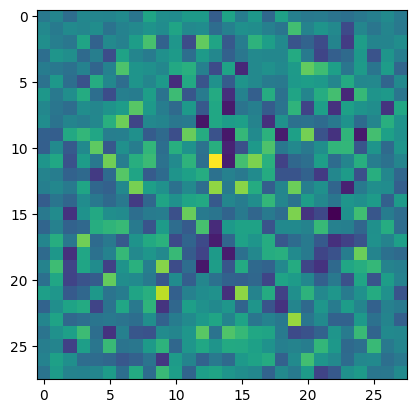

In [183]:
sample_noise = tf.random.normal(shape=[1, codings_size])
plt.imshow(gen(sample_noise)[0])

## Discriminator

In [184]:
class Discriminator(keras.Model):
    def __init__(self, name: str = 'discriminator', **kwargs):
        super(Discriminator, self).__init__(name=name, **kwargs)

        block_1 = []
        add = lambda x: block_1.append(x)
        lrelu = keras.layers.LeakyReLU

        add(keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding='same', 
                                input_shape=[img_height, img_width, img_channels])
        )
        add(keras.layers.Lambda(lrelu(alpha=0.2)))
        add(keras.layers.Dropout(rate=0.3))

        add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='same'))
        add(keras.layers.BatchNormalization())
        add(keras.layers.Lambda(lrelu(alpha=0.2)))
        add(keras.layers.Dropout(rate=0.3))

        add(keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, padding='same'))
        add(keras.layers.BatchNormalization())
        add(keras.layers.Lambda(lrelu(alpha=0.2)))
        add(keras.layers.Dropout(rate=0.3))

        add(keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same'))
        add(keras.layers.BatchNormalization())
        add(keras.layers.Lambda(lrelu(alpha=0.2)))
        add(keras.layers.Dropout(rate=0.3))


        add(keras.layers.Flatten())
        self.block = block_1
        block_1 = []

        self.dense_out = keras.layers.Dense(units=1, activation='sigmoid')


    def call(self, x: tf.Tensor):
        for layer in self.block:
            x = layer(x)

        valid = self.dense_out(x)

        return valid

    def model(self, input_shape: tuple):
        x = keras.layers.Input(shape=input_shape, batch_size=batch_size)
        return keras.Model(inputs=[x], outputs=self.call(x))

In [185]:
disc = Discriminator()
disc.model((img_height, img_width, 3)).summary()

Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(128, 28, 28, 3)]        0         
                                                                 
 conv2d_133 (Conv2D)         (128, 14, 14, 32)         2432      
                                                                 
 lambda_133 (Lambda)         (128, 14, 14, 32)         0         
                                                                 
 dropout_133 (Dropout)       (128, 14, 14, 32)         0         
                                                                 
 conv2d_134 (Conv2D)         (128, 14, 14, 64)         51264     
                                                                 
 batch_normalization_258 (Ba  (128, 14, 14, 64)        256       
 tchNormalization)                                               
                                                          

## Deep Convolutional GAN

In [186]:
class DCGAN(keras.Model):
    def __init__(self, name: str = 'dcgan', **kwargs):
        super(DCGAN, self).__init__(name=name, **kwargs)

        self.generator = Generator()
        self.discriminator = Discriminator()
        self.discriminator.compile(
            optimizer=keras.optimizers.RMSprop(learning_rate=1e-3), 
            loss=keras.losses.BinaryCrossentropy()
        )
        self.discriminator.trainable = False


    def compile(self, optimizer, loss):
        self.opt = keras.optimizers.get(optimizer)
        self.loss = keras.losses.get(loss)


    def call(self, x):
        x = self.generator(x)
        x = self.discriminator(x)
        return x

    
    def generate_images(self, inputs):
        return self.generator(inputs)

    
    @tf.function
    def train_on_batch(self, inputs, y_true):
        with tf.GradientTape() as tape:
            images = self.generator(inputs)
            y_pred = self.discriminator(images)

            loss_value = self.loss(y_true, y_pred)

        grads = tape.gradient(loss_value, self.generator.trainable_weights)
        self.opt.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        return loss_value
        

    def fit(self, data, epochs: int = 5, batch_size: int = None):

        for epoch in range(epochs):
            progress_bar = tqdm(data, ascii=True, desc='Epoch %s/%s' % (epoch + 1, epochs), position=0, ncols=80)

            for batch in progress_bar:
                # first
                noise = tf.random.normal(shape=[batch_size, codings_size])
                generated_images = self.generator(noise)

                x_fake_real = tf.concat([generated_images, batch], axis=0)

                real_pred = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
                self.discriminator.trainable = True
                self.discriminator.train_on_batch(x_fake_real, real_pred)
                
                # second
                noise = tf.random.normal(shape=[batch_size, codings_size])
                fake_pred = tf.constant([[1.]] * batch_size)
                self.discriminator.trainable = False
                loss = self.train_on_batch(noise, fake_pred)

            progress_bar.close()
            sample_noise = tf.random.normal(shape=[16, codings_size])
            plot_some_samples(self.generate_images(sample_noise)[:16])
            
            loss_sum = tf.reduce_sum(loss) / batch_size
            print('loss: %s\n' % loss_sum.numpy())

    def model(self, input_shape: tuple):
        x = keras.layers.Input(shape=input_shape, batch_size=batch_size)
        return keras.Model(inputs=[x], outputs=self.call(x))

In [187]:
gan = DCGAN()
gan.model(input_shape=(codings_size)).summary()

Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(128, 64)]               0         
                                                                 
 generator (Generator)       (128, 28, 28, 1)          1257217   
                                                                 
 discriminator (Discriminato  (128, 1)                 435457    
 r)                                                              
                                                                 
Total params: 1,692,674
Trainable params: 1,256,001
Non-trainable params: 436,673
_________________________________________________________________


In [188]:
gan.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3), 
    loss=keras.losses.BinaryCrossentropy()
)

Epoch 1/10: 100%|#############################| 429/429 [00:40<00:00, 10.48it/s]


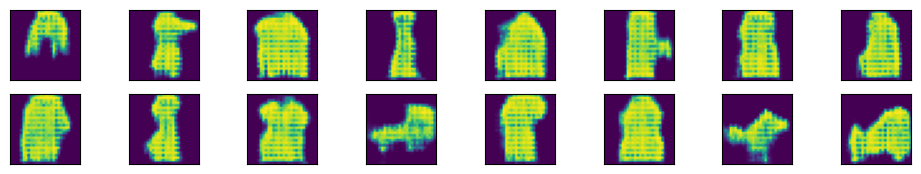

loss: 0.043290146



Epoch 2/10: 100%|#############################| 429/429 [00:40<00:00, 10.48it/s]


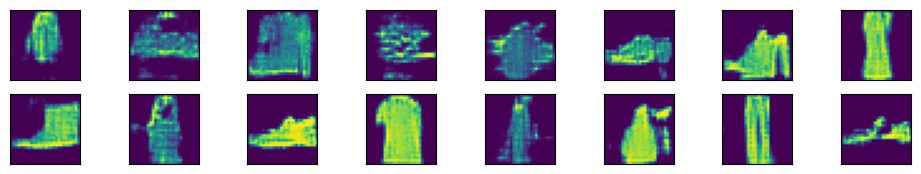

loss: 0.009533254



Epoch 3/10: 100%|#############################| 429/429 [00:24<00:00, 17.66it/s]


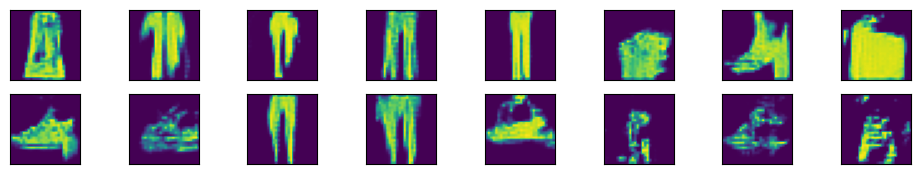

loss: 0.009122533



Epoch 4/10: 100%|#############################| 429/429 [00:24<00:00, 17.43it/s]


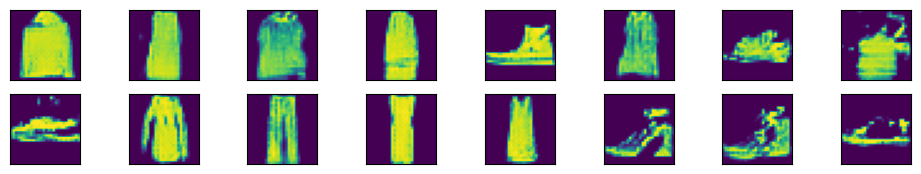

loss: 0.008619055



Epoch 5/10: 100%|#############################| 429/429 [00:24<00:00, 17.48it/s]


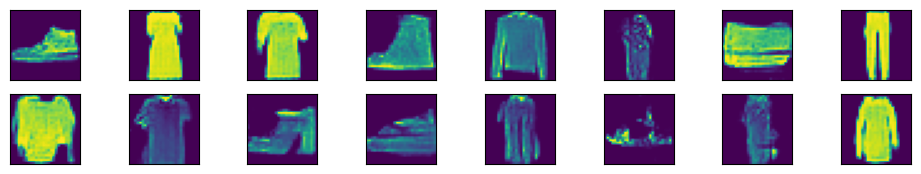

loss: 0.005884505



Epoch 6/10: 100%|#############################| 429/429 [00:24<00:00, 17.34it/s]


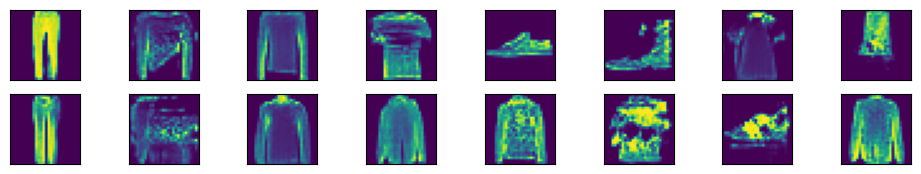

loss: 0.012412455



Epoch 7/10: 100%|#############################| 429/429 [00:24<00:00, 17.37it/s]


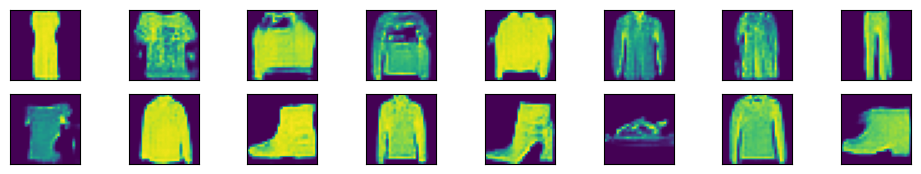

loss: 0.009484233



Epoch 8/10: 100%|#############################| 429/429 [00:24<00:00, 17.42it/s]


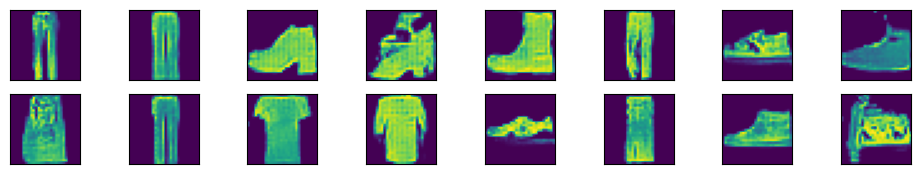

loss: 0.0067651123



Epoch 9/10: 100%|#############################| 429/429 [00:24<00:00, 17.25it/s]


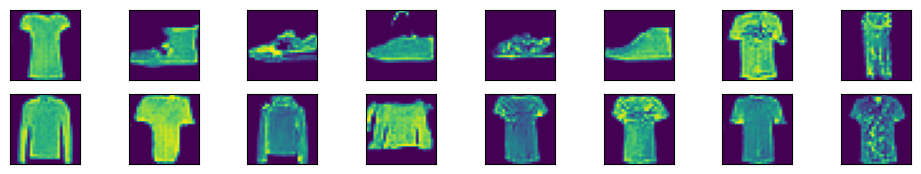

loss: 0.011989732



Epoch 10/10: 100%|############################| 429/429 [00:24<00:00, 17.36it/s]


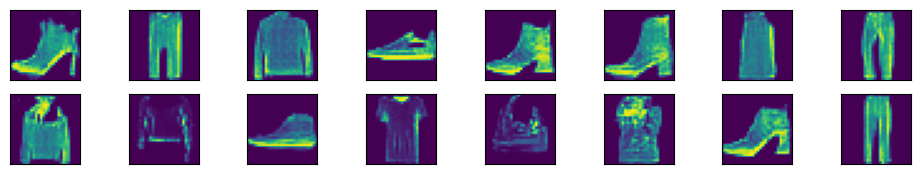

loss: 0.009026688



In [189]:
gan.fit(data=dataset, epochs=10, batch_size=batch_size)